## Notebook overview

This a notebook intended to be run in Colab. This is notebook 1.

1. Intro to RDKit: [![colab demo](https://img.shields.io/badge/Run_RDKit_intro-f9ab00?logo=googlecolab)](https://colab.research.google.com/github/matteoferla/DTC-compchem-practical/blob/main/1-basics.ipynb) — Overview of RDKit functionality
2. Intro to Forcefields & docking: [![colab demo](https://img.shields.io/badge/Run_Docking_intro-f9ab00?logo=googlecolab)](https://colab.research.google.com/github/matteoferla/DTC-compchem-practical/blob/main/2-redocking.ipynb) — Overview of forcefields in PyRosetta and redocking
3. Merging: [![colab demo](https://img.shields.io/badge/Run_RDKit_intro-f9ab00?logo=googlecolab)](https://colab.research.google.com/github/matteoferla/DTC-compchem-practical/blob/main/3-merging.ipynb) — Expample of merging

## Overview

In this notebook we will get to grips with using a Python notebook.
And will see the basics of RDKit

## Jupyter basics
A notebook is composed of 'cells'.
This is a markdown cell, it is for words, the next is for code.
The code cells can be run by pressing the play button at the top or shift+Enter.
You can freely change things as you will have to in the next cell.

You have several varieties of notebooks:

* (original=vanilla) Jupyter notebook, runs on your machine
* Jupyter lab, newer version of the above
* Colab, run on Google cloud
* Jupyter hub, the multiuser version of Jupyter

Not sure how to use a python object? Make a cell a type `help(🤖)` where 🤖 is the object.
(No, you cannot use emoji as variables in Python).
In this notebook, the imported module `dtc` will have `dtc.show_source(🤖)` will show the source code in a colourful way.

In [1]:
#@title Installation
local_debug = False
if local_debug:
    raise Exception('CURRENTLY IN DEBUG MODE.... REMEMBER TO CLEAR ALL CELLS!')
#@markdown Press the play button on the top right hand side of this cell
#@markdown once you have checked the settings.
#@markdown You will be notified that this notebook is not from Google, that is normal.

## Install all requirements and get some goodies
!pip install git+https://github.com/matteoferla/DTC-compchem-practical.git
# this will be called as:
# import DTC_compchem_practical as dtc

## Jupyter lab? use `trident-chemwidgets`
!pip install git+https://github.com/matteoferla/JSME_notebook_hack.git
!pip install --upgrade plotly

from google.colab import output  # noqa (It's a colaboratory specific repo)
output.enable_custom_widget_manager()

In [2]:
#@title RDKit
#@markdown Let's play with a molecule.
#@markdown Go to Wikipedia and
#@markdown search for a molecules and copy it's SMILEString from the infobox.

mol_name: str =  '👾👾👾'   #@param {type:"string"}
smiles: str =  '👾👾👾'   #@param {type:"string"}
if local_debug:
    mol_name: str =  'caffeine'   #@param {type:"string"}
    smiles: str =  'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'   #@param {type:"string"}

#@markdown **Q**: what is 'RDKit'?
#@markdown **Q**: what is a 'SMILEString'?

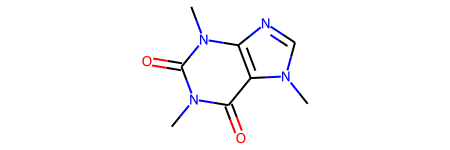

In [3]:
#@markdown Let's load it into RDKit:
from IPython.display import display
from rdkit import Chem

#RDKit can and will misbehave in Colab unless this line is called to activate it
from rdkit.Chem.Draw import IPythonConsole

mol: Chem.Mol = Chem.MolFromSmiles(smiles)
mol.SetProp('_Name', mol_name)
display(mol)

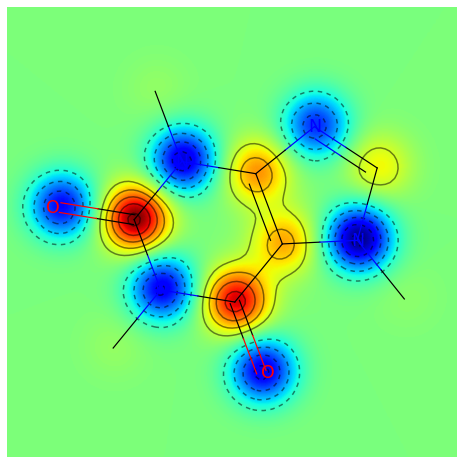

In [4]:
#@markdown Let's look at its partial charges
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import AllChem
#@markdown via `rdkit.Chem.AllChem.ComputeGasteigerCharges`
AllChem.ComputeGasteigerCharges(mol)
contribs = [a.GetDoubleProp('_GasteigerCharge') for a in mol.GetAtoms()]
#@markdown PS. If you dislike the colours,
#@markdown choose a different [colorMap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)
None
#@markdown **Q**: In addition to Marsili-Gasteiger partial charges, there is another form of partial charges, what is it?

In [ ]:
#@markdown Let's alter the molecule
from jsme_hack.rdkit import JSMERDKit
import ipywidgets as widgets

button = widgets.Button(description="Calculate", icon='fire')
output = widgets.Output(layout={'border': '1px solid black'})
display(button, output)
jsme = JSMERDKit(mol)
def on_click(remove:bool):
    alt_mol = jsme.mol
    AllChem.ComputeGasteigerCharges(alt_mol)
    contribs = [a.GetDoubleProp('_GasteigerCharge') for a in alt_mol.GetAtoms()]
    with output:
        SimilarityMaps.GetSimilarityMapFromWeights(alt_mol, contribs, colorMap='RdBu', contourLines=10)

button.on_click(on_click)
on_click(False)

In [ ]:
#@title Connectivity
#@markdown How is the molecule connected?
from typing import Tuple, List, Iterator
import operator

for i, atom in enumerate(mol.GetAtoms()):  #: Tuple[int, Chem.Atom]
    # neighbours are atoms it is bonded to
    neigh: Tuple[Chem.Atom] = atom.GetNeighbors()
    neigh_i: Tuple[int] = tuple(map(Chem.Atom.GetIdx, neigh))
    bonds: Tuple[Chem.Bond] = (mol.GetBondBetweenAtoms(i, n) for n in neigh_i)
    # bondtype is an enum `Chem.Bond.GetBondType().name`
    bondtypes: Iterator[Chem.BondType] = map(Chem.Bond.GetBondType, bonds)
    bondtype_names: Tuple[str] = tuple(map(operator.attrgetter('name'), bondtypes))
    print(f'{atom.GetSymbol()} atom (index {i}) is connected to {neigh_i} via {bondtype_names}')

In [ ]:
#@title Conformer generation
#@markdown A molecule is not only its connectivity

from rdkit.Chem import rdDistGeom, rdMolAlign, Draw

# Add Hs
hydromol = AllChem.AddHs(mol)

# Generate a single conformer
mol3d = Chem.Mol(hydromol) # making a copy
AllChem.EmbedMolecule(mol3d)
mol3d.SetProp('_Name', 'single-conf')

# Generate a 2D representation
mol2d = Chem.Mol(hydromol) # making a copy
AllChem.Compute2DCoords(mol2d)
mol2d.SetProp('_Name', '2D-repr')

# Generate multiple unique conformers
multimol = Chem.Mol(hydromol)
numconf: int = 10
param = rdDistGeom.ETKDGv2()
param.pruneRmsThresh = 0.1
cids = rdDistGeom.EmbedMultipleConfs(multimol, numconf, param)
mp = AllChem.MMFFGetMoleculeProperties(multimol, mmffVariant='MMFF94s')
AllChem.MMFFOptimizeMoleculeConfs(multimol, numThreads=0, mmffVariant='MMFF94s')
multimol.SetProp('_Name', 'multi-conf')
print(f'{multimol.GetNumConformers()} conformers made out of {numconf}')

mols = [mol2d, mol3d]
for i, conf in enumerate(multimol.GetConformers()):
    m = Chem.Mol(hydromol)
    m.AddConformer(conf)
    m.SetProp('_Name', f'conf_{i}')
    mols.append(m)
display(Draw.MolsToGridImage(mols,
                             legends=[mol.GetProp('_Name') if mol.HasProp('_Name') else '-' for mol in mols],
                             subImgSize=(200,200), useSVG=True,
                             molsPerRow=4))

In [ ]:
#@markdown Test: distort molecule and Constrained MMFF
import nglview as nv
from rdkit.Chem import rdMolAlign
from io import StringIO
from gist_import import GistImporter
from typing import Callable
align_mols: Callable[[Chem.Mol, Chem.Mol], None]= GistImporter('e9399caa07a9206d05330b0c5aca6ec1')['align_mols']


from rdkit.Geometry import Point3D

def shift_atom(mol: Chem.Mol, atom_idx:0, x_offset: float=0, y_offset: float=0, z_offset: float=0):
    """
    Shifts atom indexed ``atom_idx`` in ``conf`` by ``(atom_idx)``
    """
    conf: Chem.Conformer = mol.GetConformer()
    p: Point3D = conf.GetAtomPosition(atom_idx)
    # let's shift it by 2Å on atom 0 on axis x
    new_p: Point3D = Point3D(p.x + x_offset, p.y + y_offset, p.z + z_offset)
    conf.SetAtomPosition(atom_idx, new_p)
    mol.GetAtomWithIdx(atom_idx).SetBoolProp('Fixed', True)

# make 3D
mol2 = AllChem.AddHs(mol)
AllChem.EmbedMolecule(mol2)
## ----------------------------------------------------------------------------

#@markdown Run this a few times and change the constraints!
# Please tinker with these values:
shift_atom(mol2, atom_idx=0, x_offset=2, z_offset=5)
shift_atom(mol2, atom_idx=1, y_offset=-1)
mol2.GetAtomWithIdx(3).SetBoolProp('Fixed', True)
# in the next block `AllChem.MMFFGetMoleculeForceField.MMFFAddPositionConstraint` will be called
# constrain these.
## ----------------------------------------------------------------------------

Chem.SanitizeMol(mol2)

p = AllChem.MMFFGetMoleculeProperties(mol2, 'MMFF94')
if p is None:
    raise ValueError(f'MMFF cannot work on a molecule that has errors!')

ff = AllChem.MMFFGetMoleculeForceField(mol2, p)
# restrain
for atom in mol2.GetAtomsMatchingQuery(Chem.rdqueries.HasPropQueryAtom('Fixed', negate=False)):
    # Atom cannot move beyond 2 Aangstroems
    ff.MMFFAddPositionConstraint( atom.GetIdx(), 2, 1e5)
pre: float = ff.CalcEnergy()
outcomes = {-1: 'MMFF Minisation could not be started',
            0: 'MMFF Minisation was successful',
            1: 'MMFF Minisation was run, but the minimisation was not unsuccessful'}
try:
    m: int = ff.Minimize()
    print(outcomes.get(m, "Iä! Iä! Cthulhu fhtagn! Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn"))
except RuntimeError as error:
    print(f'MMFF minimisation failed {error.__class__.__name__}: {error}')

post: float = ff.CalcEnergy()
print(f'∆G went from {pre} to {post} kcal/mol')
#rdMolAlign.AlignMol(mol2, mol)
#align_mols(mol2, mol)
view = nv.show_rdkit(mol2)
# fh = StringIO(Chem.MolToPDBBlock(mol))
# view.add_component(fh, ext='mol')

display(view)
#@markdown **Q**: Why is there a drop in Gibbs free energy (a potential)?
#@markdown **Q**: How does this relate to entropy of the system (think chelate effect)?
#@markdown **Q**: What does `AllChem.EmbedMolecule` do?
#@markdown **Q**: What is the difference between a Chem.Mol instance and its Chem.Conformer(s)? Why does the latter have atomic positions?

In [ ]:
#@title Analyse hits

# TBC

In [ ]:
## The following are not complete

In [ ]:
#@title Download off Fragalysis
#@markdown Choose a target
target_name = '👾👾👾'   #@param {type:"string"}

from rdkit import Chem
from IPython.display import display
from typing import Dict
import DTC_compchem_practical as dtc

#@markdown This will add the variables `pdb_filename`, `metadata_filename` and `sdf_filename`.
filenames: Dict[str, str] = dtc.download_fragalysis(target_name, 'input')
pdb_filename: str = filenames['reference.pdb']
metadata_filename: str = filenames['metadata.csv']
sdf_filename: str = filenames['combined.sdf']

In [ ]:
import nglview as nv
import io
import numpy as np

max_show = 100
df = mol_df
#df = mol_df.drop_duplicates('site_name')  # filter if wanted
    
view = nv.NGLWidget()

view.add_component(io.StringIO(pdb_block), ext='pdb')
for mol in df.ROMol[:max_show]:
    fh = io.StringIO(Chem.MolToMolBlock(mol))
    view.add_component(fh, ext='mol')
#view.control.zoom(1.)
view

In [ ]:
from misc_funs import calc_distances, distance_heatmap
from rdkit.Chem import PandasTools, rdShapeHelpers, rdmolops, Descriptors
import plotly.graph_objects as go

# filter if wanted
df = mol_df
#df = mol_df.drop_duplicates('site_name')

# this is not working!
#from misc_funs import distance_heatmap
#distance_heatmap( df )

mols = df.ROMol.apply(rdmolops.AddHs)
matrix: np.array = calc_distances(mols)
go.Figure(data=go.Heatmap(
                            x = mols.apply(lambda m: m.GetProp('_Name')).tolist(),
                            y = mols.apply(lambda m: m.GetProp('_Name')).tolist(),
                            z = matrix,
                            colorscale = 'hot'
                        )
         )



## Questions

* How many small molecules are there?
* How many sites?
* If you have a dimer, what do you see as a problem?
* What data would you like to see in the above table and why?
* The above simply gets the molecular replacement template as the target. Is that wise?
* The table has a `site_name` column. What would be a good approach to choose what sites to focus on?